In [2]:
!pip install rembg==2.0.56

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 49.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.6 MB/s eta 0:00:00


# Imports

In [21]:
import os
import csv
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from rembg import new_session, remove

# Constants

In [4]:
BASE_PATH = '/kaggle/input/key-images/'

# Model

# Helper Functions

In [15]:
def load_general_use_model(model_name='isnet-general-use'):
    session = new_session(model_name)
    return session


def remove_bg(input_img):
    # Make session
    session_isnet_general_use = load_general_use_model()

    # Output image
    image = remove(input_img, session=session_isnet_general_use, only_mask=False)
    mask = remove(input_img, session=session_isnet_general_use, only_mask=True)

    return np.array(image), np.array(mask)


def get_dataset_images_path(base_path):
    image_names = []
    images_path = []
    for _, _, img_names in os.walk(base_path):
        image_names.extend(img_names)
    
    images_path = [os.path.join(base_path, img_name) for img_name in image_names if "csv" not in img_name]
    return images_path


def plt_img(img_data, cmap='gray'):
    plt.imshow(img_data, cmap=cmap)
    plt.axis('on')
    plt.show()

# SIFT

In [25]:
images_path = sorted(get_dataset_images_path(BASE_PATH))

key_images = []
for image_path in images_path:

    rgb_img = Image.open(image_path)
    
    image, mask = remove_bg(rgb_img)
    
    _, mask_img = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    contours, _ = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x,y,w,h = cv2.boundingRect(contours[0])
    cropped_image = image[y:y+h, x:x+w]
    
    greyed_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    
    key_images.append(greyed_image)

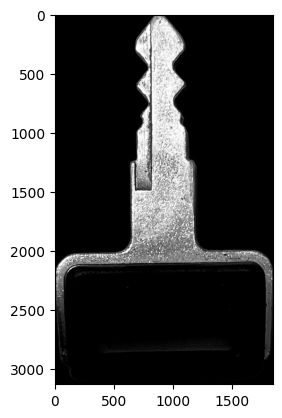

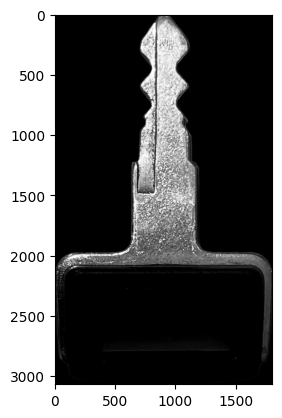

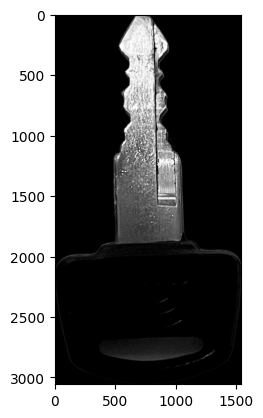

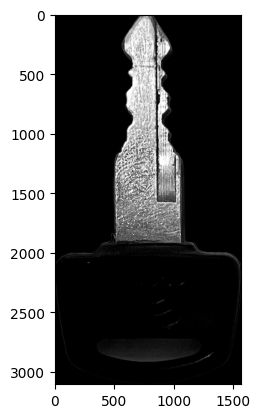

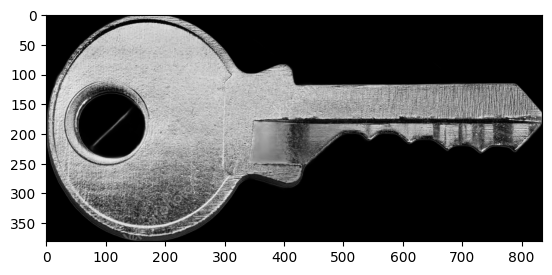

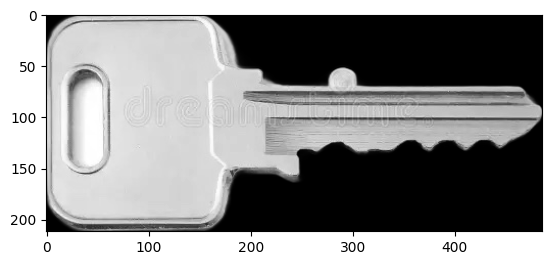

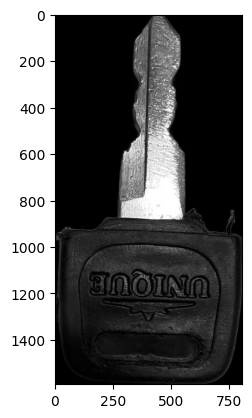

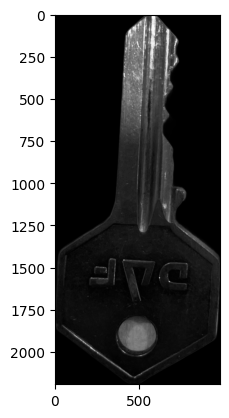

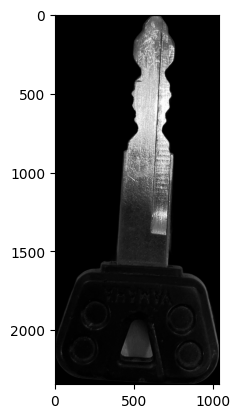

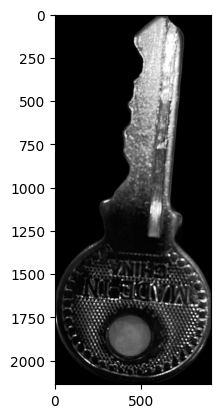

[None, None, None, None, None, None, None, None, None, None]

In [29]:
[plt_img(img) for img in key_images]

In [30]:
sift = cv2.SIFT_create()
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

keypoints, descriptors = [], []
for image in key_images:
    kp, ds = sift.detectAndCompute(image, None)
    keypoints.append(kp), descriptors.append(ds)

In [31]:
for des in descriptors:
    print(des.shape)

(10547, 128)
(8896, 128)
(3753, 128)
(6348, 128)
(1290, 128)
(175, 128)
(5740, 128)
(1494, 128)
(7589, 128)
(7616, 128)


In [32]:
match_matrix = []
score_matrix = []

for des1 in descriptors:
    
    match_counts = []
    percentages = []
    
    for des2 in descriptors:
        match_count = len(bf.match(des1, des2))
        match_counts.append(match_count)
        percentages.append(match_count / len(des1))
        
    match_matrix.append(match_counts)
    score_matrix.append(percentages)
    
    print(f"Image done")

Image done
Image done
Image done
Image done
Image done
Image done
Image done
Image done
Image done
Image done


In [33]:
print("Match Matrix")
for row in match_matrix:
    print(row)
    
print("Score Matrix")
for row in score_matrix:
    print(row)

Match Matrix
[10547, 2738, 1514, 2176, 529, 83, 1720, 438, 2346, 1825]
[2738, 8896, 1461, 2091, 482, 75, 1617, 465, 2139, 1789]
[1514, 1461, 3753, 1275, 397, 71, 1050, 334, 1252, 1089]
[2176, 2091, 1275, 6348, 462, 65, 1411, 393, 1858, 1457]
[529, 482, 397, 462, 1290, 49, 438, 217, 486, 461]
[83, 75, 71, 65, 49, 175, 64, 52, 66, 61]
[1720, 1617, 1050, 1411, 438, 64, 5740, 437, 1569, 1426]
[438, 465, 334, 393, 217, 52, 437, 1494, 428, 459]
[2346, 2139, 1252, 1858, 486, 66, 1569, 428, 7589, 1649]
[1825, 1789, 1089, 1457, 461, 61, 1426, 459, 1649, 7616]
Score Matrix
[1.0, 0.25959988622357066, 0.14354792832084953, 0.20631459182705983, 0.05015644259031004, 0.007869536361050535, 0.1630795486868304, 0.04152839670048355, 0.2224329193135489, 0.1730349862520148]
[0.30777877697841727, 1.0, 0.16423111510791366, 0.23504946043165467, 0.054181654676258996, 0.008430755395683453, 0.18176708633093525, 0.05227068345323741, 0.24044514388489208, 0.20110161870503598]
[0.4034106048494538, 0.38928856914468424

In [41]:
image_names = [path.split('/')[-1].split('.')[0] for path in images_path]

rankings = {}

for i in range(len(image_names)):
    current = []
    for j in range(len(image_names)):
        current.append((image_names[j], score_matrix[i][j]))
        
    current.sort(key=lambda x: x[1], reverse=True)
    rankings[image_names[i]] = current


In [43]:
for key, value in rankings.items():
    print(key, value,'\n')

1a [('1a', 1.0), ('1b', 0.25959988622357066), ('8', 0.2224329193135489), ('2b', 0.20631459182705983), ('9', 0.1730349862520148), ('5', 0.1630795486868304), ('2a', 0.14354792832084953), ('3', 0.05015644259031004), ('7', 0.04152839670048355), ('4', 0.007869536361050535)] 

1b [('1b', 1.0), ('1a', 0.30777877697841727), ('8', 0.24044514388489208), ('2b', 0.23504946043165467), ('9', 0.20110161870503598), ('5', 0.18176708633093525), ('2a', 0.16423111510791366), ('3', 0.054181654676258996), ('7', 0.05227068345323741), ('4', 0.008430755395683453)] 

2a [('2a', 1.0), ('1a', 0.4034106048494538), ('1b', 0.38928856914468424), ('2b', 0.33972821742605913), ('8', 0.33359978683719693), ('9', 0.290167865707434), ('5', 0.2797761790567546), ('3', 0.10578204103383959), ('7', 0.08899547029043432), ('4', 0.01891819877431388)] 

2b [('2b', 1.0), ('1a', 0.3427851291745432), ('1b', 0.32939508506616255), ('8', 0.29269061121613105), ('9', 0.22952110901071204), ('5', 0.22227473219911784), ('2a', 0.200850661625708

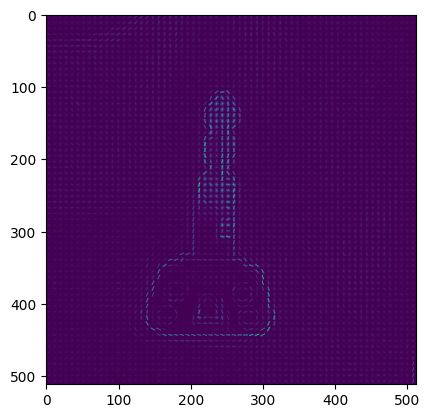

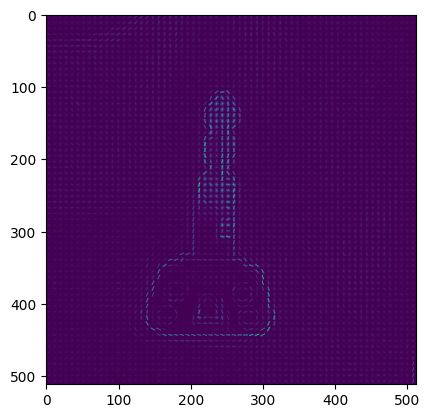

Similarity score: 0.9999999999999939


In [65]:
import numpy as np

from skimage import exposure
from skimage.io import imread
from skimage.feature import hog
from skimage.transform import resize

from sklearn.metrics.pairwise import cosine_similarity

def compute_hog(image):
    
    # Some constants
    DIM = 512
    PPC = 16
    CPB = 1
    
    # Resize
    image = resize(image, (DIM, DIM), anti_aliasing=True)
    
    # Compute HOG features
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    
    # Enhance contrast of HOG image for visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    
    plt.imshow(hog_image_rescaled)
    plt.axis('on')
    plt.show()
    
    return fd

def compute_similarity(image1, image2):
    # Compute HOG features for both images
    hog_features1 = compute_hog(image1)
    hog_features2 = compute_hog(image2)
    
    # Compute cosine similarity between HOG feature vectors
    similarity = cosine_similarity([hog_features1], [hog_features2])[0][0]
    return similarity

# Example usage:
# Load images
image1 = imread(f'{BASE_PATH}/8.jpg')
image2 = imread(f'{BASE_PATH}/8.jpg')

# Compute similarity between images
similarity_score = compute_similarity(image1, image2)
print("Similarity score:", similarity_score)

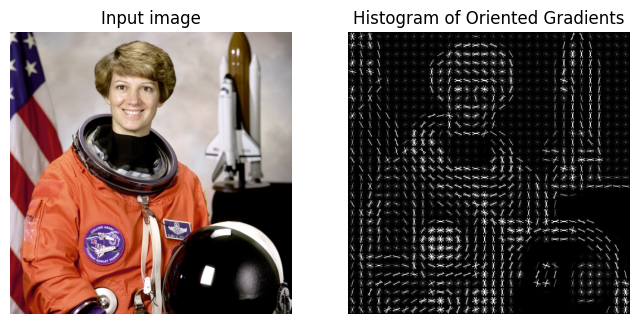

In [54]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = data.astronaut()

ppc = 16

fd, hog_image = hog(
    image,
    orientations=8,
    pixels_per_cell=(ppc, ppc),
    cells_per_block=(1, 1),
    visualize=True,
    channel_axis=-1,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

# HOG Test

In [66]:
import numpy as np

from skimage import exposure
from skimage.io import imread
from skimage.feature import hog
from skimage.transform import resize

from sklearn.metrics.pairwise import cosine_similarity

def compute_hog(image):
    
    # Some constants
    DIM = 512
    PPC = 16
    CPB = 1
    
    # Resize
    image = resize(image, (DIM, DIM), anti_aliasing=True)
    
    # Compute HOG features
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

    return fd

def compute_similarity(fd1, fd2):
    
    # Compute cosine similarity between HOG feature vectors
    return cosine_similarity([fd1], [fd2])[0][0]

image_paths = sorted(get_dataset_images_path(BASE_PATH))
image_names = [path.split('/')[-1].split('.')[0] 
               for path in image_paths]

fd = [compute_hog(image) for image in key_images]

matrix = [[compute_similarity(x, y) for y in fd] for x in fd]

matrix

ValueError: Only images with two spatial dimensions are supported. If using with color/multichannel images, specify `channel_axis`.